In [1]:
!ls

Data                         weather_classification.ipynb
README.md                    weather_prediction.ipynb
images


#### Step One: Import all the necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from tensorflow.keras import layers

import io
import itertools
import base64
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import classification_report, precision_score, recall_score

#### Step Two: Loading Data.

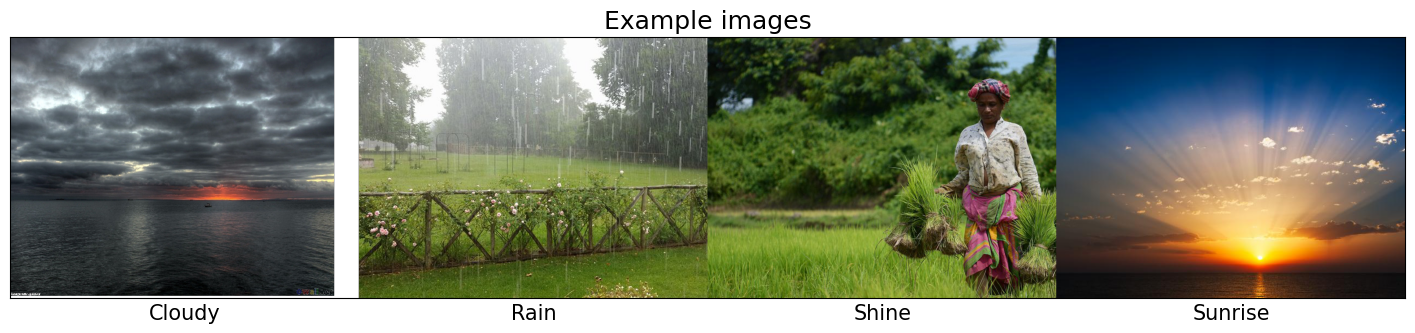

In [3]:
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

cloudy_img = Image.open('images/Cloudy/cloudy136.jpg')
rain_img = Image.open('images/Rain/rain180.jpg')
shine_img = Image.open('images/Shine/shine254.jpeg')
sunrise_img = Image.open('images/Sunrise/sunrise1.jpg')
example_imgs = [cloudy_img, rain_img, shine_img, sunrise_img]

w, h = example_imgs[1].size
grid = Image.new('RGBA', size = (4 * w, h))
grid_w, grid_h = grid.size
ls = grid_w / 4   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box = (i % 4 * w, i // 4 * h))

plt.figure(figsize = (18,10))
plt.title('Example images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls - ls/2, ls * 2 - ls / 2, ls * 3 - ls / 2, ls * 4 - ls / 2], 
           classes, fontsize = 15)
plt.tick_params(axis = u'both', which = u'both',length = 0)
plt.yticks([])
plt.show()

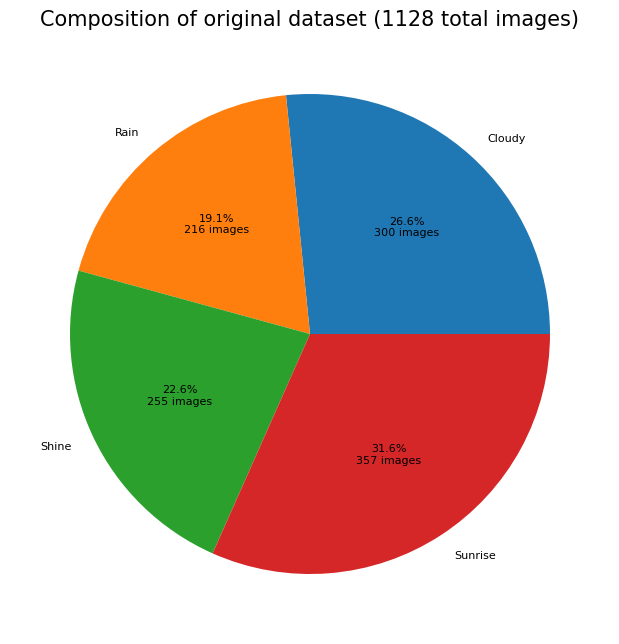

In [4]:
# Image distribution in each folder.
cloudy_images = len(os.listdir('images/Cloudy/'))
rain_images = len(os.listdir('images/Rain/'))
shine_images = len(os.listdir('images/Shine/'))
sunrise_images = len(os.listdir('images/Sunrise/'))

# Plot distribution of image classes
def label_pie(pct, allvals):
    absolute = int(round(pct / 100. * np.sum(allvals)))
    return "{:.1f}%\n{:d} images".format(pct, absolute)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')
weather_conditions = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

total_images = [cloudy_images, rain_images, shine_images, sunrise_images]
ax.pie(total_images, labels = weather_conditions, autopct = lambda pct: 
       label_pie(pct, total_images), textprops={'fontsize': 8})

plt.title('Composition of original dataset ({} total images)'.format(sum(total_images)),
          fontsize=15)
plt.show()

- Define the weather condition.
- Create a dictionary that takes some parameters that we will path to a function to read our images.

In [5]:
weather_cond = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

In [6]:
weather_dict = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": weather_cond
}

- Create a function that will load our data (tf.keras.utils.image_dataset_from_directory).
- Then pass our dictionary above and load the data.

In [7]:
train_weather = tf.keras.utils.image_dataset_from_directory(
    "images",
    subset = "training",
    ** weather_dict
)

test_weather = tf.keras.utils.image_dataset_from_directory(
  "images",
  subset = "validation",
    ** weather_dict
)

Found 1126 files belonging to 4 classes.
Using 901 files for training.
Metal device set to: Apple M1 Pro
Found 1126 files belonging to 4 classes.
Using 225 files for validation.


2022-11-13 00:42:22.687092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 00:42:22.687241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Lets check our data types.
test_weather
train_weather

# As showing below... Our data type is a batch dataset class.

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

#### Step Three: Exploritory Data Analysis

- Let's explore our data batch.
    - NOTE: As stated in our dictionary above, a batch size has 32 images.

In [9]:
first_batch = train_weather.take(1)
first_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [10]:
# Lets check the first image in our batch
images, labels = list(first_batch)[0]
first_image = images[0]

2022-11-13 00:42:22.862112: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[115.     , 115.     , 115.     ],
       [115.     , 115.     , 115.     ],
       [114.83984, 114.83984, 114.83984]], dtype=float32)>

As showing above Tensorflow stored our images as Numpy Array. 

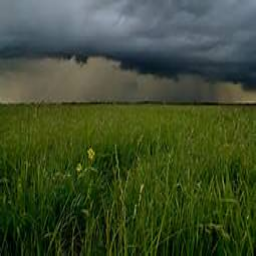

In [12]:
# Lets display our image using PIL image.
Image.fromarray(images[0].numpy().astype("uint8"))

In [13]:
print(labels[0])

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [14]:
second_batch = train_weather.take(2)
second_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [15]:
# Lets check the second image in our second batch.
images, labels = list(second_batch)[1]
second_image = images[1]

In [16]:
second_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[140.98438, 140.     , 140.     ],
       [140.52487, 140.     , 140.     ],
       [139.88867, 139.88867, 139.88867]], dtype=float32)>

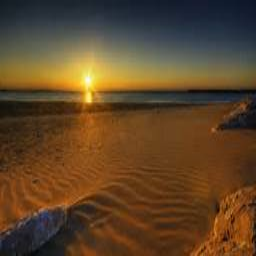

In [17]:
# Lets display our image using PIL image.
Image.fromarray(images[16].numpy().astype("uint8"))

In [18]:
print(labels[2])

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


#### Step Four: Preparing Data for Modeling

In [19]:
# Training & Testing Data
X_train = train_weather.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
x_test = test_weather.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

##### First Model

- Create a Sequential model.
    - rescale the data for easy Neural Networks prediction.
    - Create a 2D convolutional layer that scan our images & extract features.
    - Create a flatten layer.
    - create a dense layer to get the prediction.

In [20]:
model = Sequential([
  tf.keras.layers.Rescaling(1. / 255),
  layers.Conv2D(16, 3, padding = 'same', activation='relu', input_shape = (256, 256, 3)),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(len(weather_cond))
])

In [21]:
# Compile the model for prediction
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [22]:
# Fit the model to the training data
base_model = model.fit(
    X_train,
    validation_data = x_test,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2022-11-13 00:42:24.233477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 32.0513 - accuracy: 0.5494

2022-11-13 00:42:39.975151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 20s 664ms/step - loss: 32.0513 - accuracy: 0.5494 - val_loss: 4.1149 - val_accuracy: 0.8044
Epoch 2/10
29/29 [==============================] - 19s 646ms/step - loss: 3.6156 - accuracy: 0.7747 - val_loss: 1.4989 - val_accuracy: 0.8178
Epoch 3/10
29/29 [==============================] - 19s 645ms/step - loss: 0.8066 - accuracy: 0.8313 - val_loss: 0.8070 - val_accuracy: 0.8533
Epoch 4/10
29/29 [==============================] - 19s 645ms/step - loss: 0.4293 - accuracy: 0.9001 - val_loss: 0.5538 - val_accuracy: 0.8356
Epoch 5/10
29/29 [==============================] - 19s 645ms/step - loss: 0.2003 - accuracy: 0.9390 - val_loss: 0.6070 - val_accuracy: 0.8622
Epoch 6/10
29/29 [==============================] - 19s 645ms/step - loss: 0.1065 - accuracy: 0.9700 - val_loss: 0.5135 - val_accuracy: 0.8756
Epoch 7/10
29/29 [==============================] - 19s 644ms/step - loss: 0.1143 - accuracy: 0.9667 - val_loss: 0.5453 - val_accuracy: 0.8578
Epoch 8/1

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 134,218,820
Trainable params: 134,218,820
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

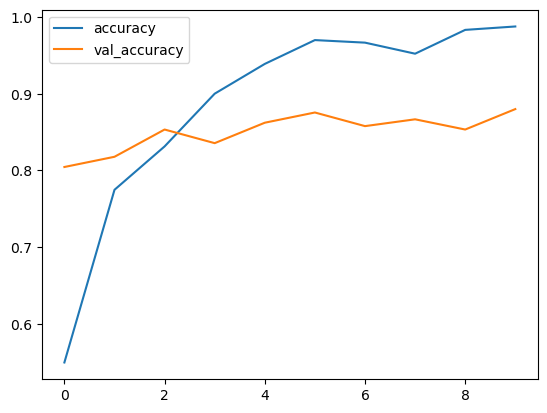

In [24]:
base_model_df = pd.DataFrame.from_dict(base_model.history)
base_model_df[["accuracy", "val_accuracy"]].plot()

According to the results above. Our model indicates that training accuracy is doing really well compared to the validation accuracy. Or in other words this indicates that our model is a little bit overfitting.

This also tells me, our model picks on random variation from our training data. Or maybe the model picked on a cloudy image and classified it as sunset.

#### Second Model: Improving our model accuracy by tuning it.


- Create a function that will train the model.
- Add a MaxPooling2D layer to help reduce overfitting.
- Add a dropout layer.

In [37]:
def train_model(network, epochs = 25):
    model = Sequential(network)

    model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

    history = model.fit(
      X_train,
      validation_data = x_test,
      epochs = epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [38]:
network = [
  tf.keras.layers.Rescaling(1. / 255),
  layers.Conv2D(16, 4, padding = 'same', activation = 'relu', input_shape = (256, 256 , 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(len(weather_cond))
]

history_df, model = train_model(network)

Epoch 1/25
 1/29 [>.............................] - ETA: 10s - loss: 1.3716 - accuracy: 0.3750

2022-11-13 00:48:32.315505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.4639

2022-11-13 00:48:34.859276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 3s 96ms/step - loss: 1.2621 - accuracy: 0.4639 - val_loss: 0.7318 - val_accuracy: 0.6533
Epoch 2/25
29/29 [==============================] - 3s 90ms/step - loss: 0.6264 - accuracy: 0.7725 - val_loss: 0.5920 - val_accuracy: 0.8089
Epoch 3/25
29/29 [==============================] - 3s 90ms/step - loss: 0.4286 - accuracy: 0.8413 - val_loss: 0.3529 - val_accuracy: 0.8889
Epoch 4/25
29/29 [==============================] - 3s 91ms/step - loss: 0.3047 - accuracy: 0.8901 - val_loss: 0.2886 - val_accuracy: 0.8844
Epoch 5/25
29/29 [==============================] - 3s 90ms/step - loss: 0.2373 - accuracy: 0.9090 - val_loss: 0.4589 - val_accuracy: 0.8667
Epoch 6/25
29/29 [==============================] - 3s 95ms/step - loss: 0.2391 - accuracy: 0.9101 - val_loss: 0.3065 - val_accuracy: 0.8844
Epoch 7/25
29/29 [==============================] - 3s 93ms/step - loss: 0.1814 - accuracy: 0.9334 - val_loss: 0.3110 - val_accuracy: 0.8533
Epoch 8/25
29/29 [======

<AxesSubplot: >

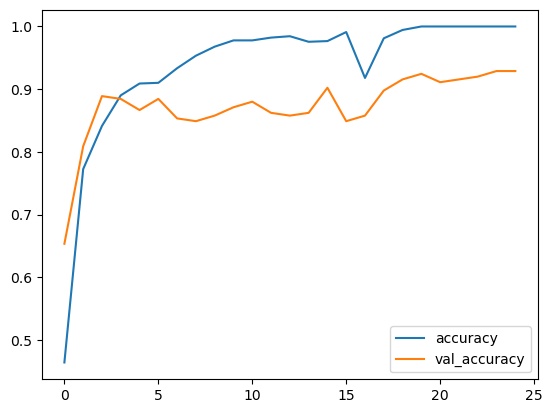

In [39]:
history_df[["accuracy", "val_accuracy"]].plot()

As showing in our graph above... Our model validation accuracy improved to a much better validation accuracy at about 93% accurate, which is way better compared to the previous model.

In [40]:
# Check for model prediction.
preds = model.predict(x_test)

5/8 [=================>............] - ETA: 0s

2022-11-13 00:49:57.157478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 37ms/step


In [41]:
# Converting preds to a numpy array for easy visualization.
predicted_weather_cond = np.argmax(preds, axis = 1)
predicted_weather_cond

array([3, 3, 3, 3, 3, 3, 1, 2, 1, 2, 2, 2, 2, 1, 3, 1, 2, 0, 3, 0, 2, 3,
       2, 2, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 2, 1, 0, 1, 0, 2, 2, 3, 0,
       1, 2, 2, 1, 3, 2, 3, 2, 0, 0, 0, 2, 1, 0, 3, 0, 3, 3, 0, 2, 3, 3,
       3, 3, 3, 2, 0, 3, 2, 1, 2, 3, 0, 3, 2, 0, 3, 1, 1, 0, 3, 0, 0, 0,
       2, 2, 3, 3, 0, 3, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 2, 2, 0, 2, 0,
       2, 2, 3, 3, 0, 1, 2, 3, 1, 0, 2, 0, 1, 3, 3, 0, 0, 2, 2, 1, 3, 0,
       0, 0, 3, 0, 2, 0, 1, 2, 0, 3, 2, 1, 0, 3, 1, 0, 0, 2, 2, 0, 2, 0,
       3, 1, 3, 0, 1, 1, 3, 2, 3, 1, 0, 0, 2, 2, 2, 1, 3, 2, 0, 3, 1, 2,
       0, 3, 3, 3, 3, 3, 2, 0, 3, 0, 0, 3, 2, 0, 0, 3, 2, 3, 1, 3, 2, 2,
       0, 1, 1, 2, 0, 3, 0, 3, 0, 0, 2, 1, 3, 0, 2, 3, 3, 0, 2, 3, 3, 3,
       3, 1, 3, 3, 2])

In [42]:
# Getting the actual labels from the x_test dataset.
actual_labels = np.concatenate([y for x, y in x_test], axis = 0)

In [43]:
actual_weather_cond = np.argmax(preds, axis = 1)

In [44]:
# Create a list of all images using itertools.
actual_image = [x.numpy().astype("uint8") for x, y in x_test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [45]:
# Use the pandas zip function to put all the above arrays into a pandas dataframe.
pred_df = pd.DataFrame(zip(actual_weather_cond, predicted_weather_cond, actual_image), 
                       columns = ["Actual Weather", "Predicted Weather", "Image"])

In [46]:
# Convert column names to weather classification.
pred_df["Actual Weather"] = pred_df["Actual Weather"].apply(lambda x: weather_cond[x])
pred_df["Predicted Weather"] = pred_df["Predicted Weather"].apply(lambda x: weather_cond[x])

In [53]:
pred_df.head(20)

,Actual Weather,Predicted Weather,Image
0,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
1,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
2,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
3,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
4,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
5,Sunrise,Sunrise,<PIL.Image.Image image mode=RGB size=256x256 a...
6,Rain,Rain,<PIL.Image.Image image mode=RGB size=256x256 a...
7,Shine,Shine,<PIL.Image.Image image mode=RGB size=256x256 a...
8,Rain,Rain,<PIL.Image.Image image mode=RGB size=256x256 a...
9,Shine,Shine,<PIL.Image.Image image mode=RGB size=256x256 a...


In [82]:
# Display the predicted images using base64 and io
def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src = "data: Image/jpg;base64,{img_str}">'
    
    
pred_df.head(20).style.format({'Image': image_formatter})

Overall, our model classification accuracy in our validation dataset is about 93% accurate, which is quite good based on the predicted results above. 